In [13]:
def read_poscar(path):

    """
    Create list of atomic numbers, xyz coordinates and uc matrix
    from poscar file.
    """
    
    atomic_number_map_dict = {
        "C" : 6,
        "H" : 1,
        "N" : 7,
        "O" : 8,
    }

    uc_mat = [
        [0,0,0],
        [0,0,0],
        [0,0,0],
    ]
    atom_element_list = list()
    xyz_list = list()
    with open(path, "r") as fopen:
        for line_idx, line in enumerate(fopen):
            data = line.rstrip().lstrip().split()
            if len(data) == 0:
                continue
            if line_idx == 2:
                uc_mat[0] = [float(v) for v in data]
            elif line_idx == 3:
                uc_mat[1] = [float(v) for v in data]
            elif line_idx == 4:
                uc_mat[2] = [float(v) for v in data]
            elif line_idx == 5:
                for e in data:
                    atom_element_list.append(
                        [atomic_number_map_dict[e], 0,])
            elif line_idx == 6:
                for i, n in enumerate(data):
                    atom_element_list[i][1] = int(n)
            elif line_idx > 8:
                xyz_list.append(
                    [float(v) for v in data[:3]])
                
    atomic_number_list = list()
    for A, N in atom_element_list:
        for _ in range(N):
            atomic_number_list.append(A)
            
    return atomic_number_list, xyz_list, uc_mat

## Download and process poscar files

We download a `.poscar` file from the openkim archive.

In [12]:
#!curl -O https://openkim.org/files/TE_873344092083_001-and-SM_107643900657_001-1711661380-tr/instance-2.poscar
#!curl -O https://openkim.org/files/TE_636090065077_001-and-SM_198543900691_000-1711661408-tr/instance-2.poscar
#!curl -O https://openkim.org/files/TE_636090065077_001-and-SM_107643900657_001-1711661416-tr/instance-2.poscar
### Chemistry in structure too weird N-N bond length of 1.93 \AA ?
#!curl -O https://openkim.org/files/TE_357033213726_001-and-SM_198543900691_000-1711661384-tr/instance-2.poscar
#!curl -O https://openkim.org/files/TE_288919937723_001-and-SM_198543900691_000-1711661363-tr/instance-2.poscar
!curl -O https://openkim.org/files/TE_503683569064_001-and-SM_198543900691_000-1712183345-tr/instance-2.poscar
### Weird chemistry
#!curl -O https://openkim.org/files/TE_506166234426_001-and-SM_198543900691_000-1713563348-tr/instance-2.poscar
#!curl -O https://openkim.org/files/TE_307285905143_001-and-SM_107643900657_001-1715205925-tr/instance-2.poscar
#!curl -O https://openkim.org/files/TE_215701241474_001-and-SM_198543900691_000-1711661405-tr/instance-2.poscar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11104  100 11104    0     0  20716      0 --:--:-- --:--:-- --:--:-- 20716


## Get the coordinates, atomic numbers and unit cell ready.

In [ ]:
atomic_number_list, xyz_list, uc_mat = read_poscar("instance-2.poscar")

import numpy as np
atomic_number_list = np.array(atomic_number_list)
xyz_list = np.array(xyz_list)
uc_mat = np.array(uc_mat)

from openmm.app.internal.unitcell import computeLengthsAndAngles
a,b,c,alpha,beta,gamma = computeLengthsAndAngles(uc_mat)
alpha *= 180./np.pi
beta  *= 180./np.pi
gamma *= 180./np.pi

import gemmi
strc = gemmi.Structure()
strc.spacegroup_hm = "P1"
strc.cell = gemmi.UnitCell(a,b,c,alpha,beta,gamma)

## Use xtalmdscripts to build the structure

The structure will be stored in a list of rdkit molecule instances. The code works **much** faster if openeye-toolkits package is installed (license required).

In [2]:
from xtalmdscripts.supercellbuilding import make_supercell

replicated_mol_list, _, _ = make_supercell.generate_replicated_mol_list(
    cell=strc.cell,
    atom_crds_ortho=xyz_list,
    atom_num=atomic_number_list,
    a_min_max=[0,0],
    b_min_max=[0,0],
    c_min_max=[0,0],
    addhs=False,
    addwater=False,
    removewater=False,
    N_iterations_protonation=0,
    use_openeye=True,
    label_residues=False,
    acmatrix=None)

Calculate the total charge of the molecular system. Should be zero.

In [15]:
from rdkit.Chem import AllChem as Chem
[Chem.Compute2DCoords(rdmol) for rdmol in replicated_mol_list]
q = 0
for mol in replicated_mol_list:
    q += Chem.GetFormalCharge(mol)
print(
    "Total charge of the unit cell", q)

Total charge of the unit cell 0


## Check the molecules

Draw all ther molecules in the unit cell. Make sure they look reasonable.

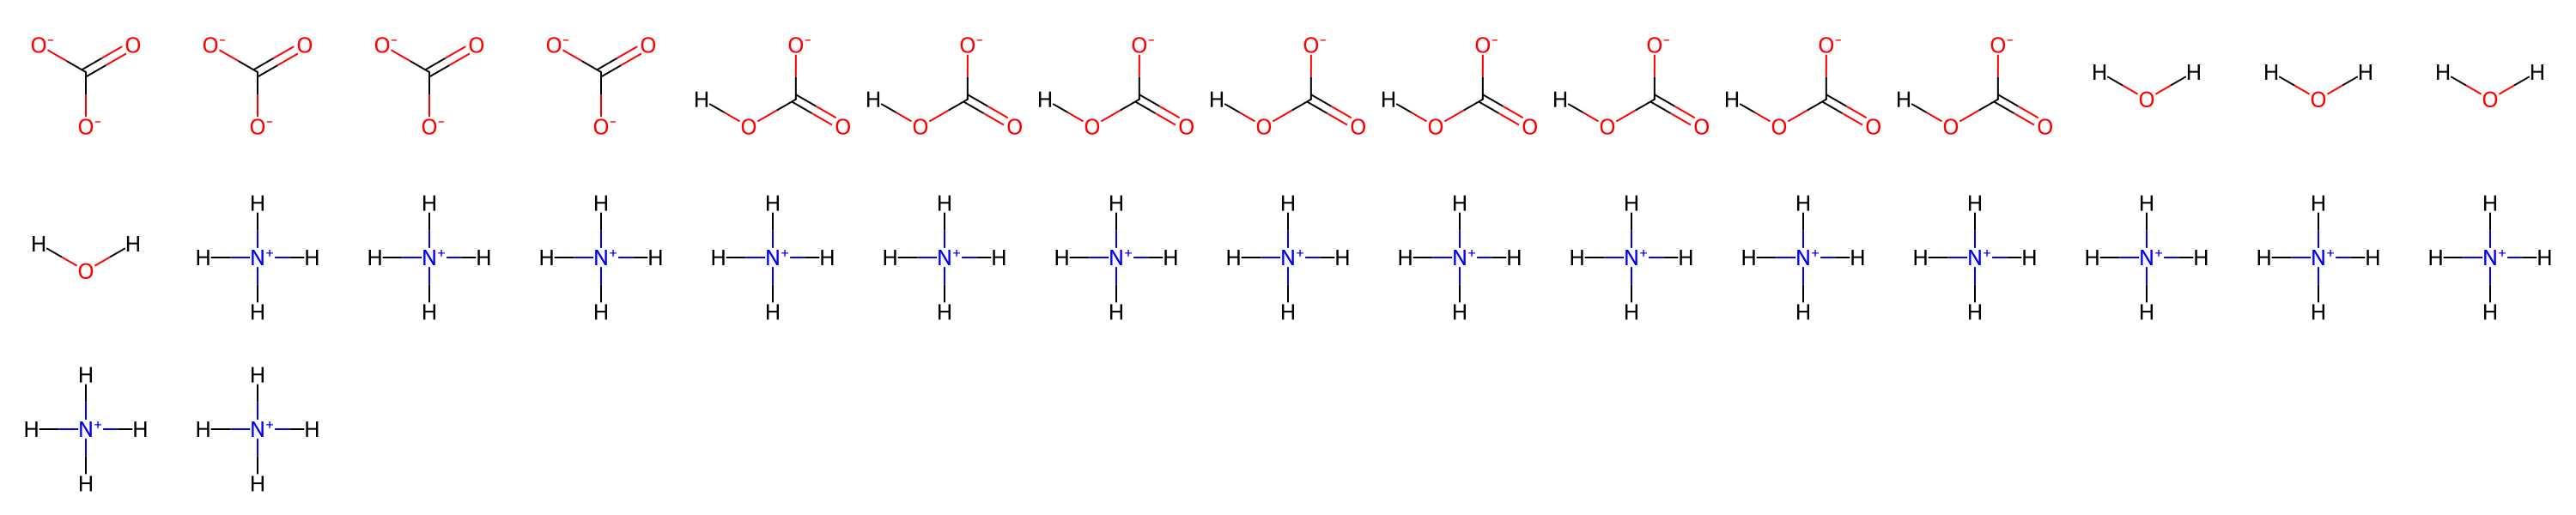

In [18]:
svg = Chem.Draw.MolsToGridImage(
    replicated_mol_list, molsPerRow=15)
svg

## Build Lammps input

Build Lammps input file. Right now this works with the Openff 2.0.0 (code name *Sage*) force field. Other force fields from the OpenFF family will work as well. 

In [19]:
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.topology import Topology, Molecule
from openmm import unit

topology = Topology()
offmol_list = list()
for mol in replicated_mol_list:
    offmol = Molecule.from_rdkit(mol)
    offmol.assign_partial_charges('am1bcc')
    topology.add_molecule(offmol)
    offmol_list.append(offmol)
topology.box_vectors = uc_mat * unit.angstrom
forcefield = ForceField("openff-2.0.0.offxml")
interchange = forcefield.create_interchange(
    topology, charge_from_molecules=topology.molecules)
interchange.to_lammps("input.inp")

In [20]:
!cat input.inp

Title

148 atoms
116 bonds
144 angles
24 dihedrals
36 impropers

8 atom types
4 bond types
3 angle types
3 dihedral types
1 improper types
-2.078460969 4.108086081 xlo xhi
-1.5 13.69398143 ylo yhi
0 10.54788165 zlo zhi
0.0 0.0 0.0 xy xz yz

Masses

1	12.01078
2	15.99943
3	1.007947
4	15.99943
5	1.007947
6	15.99943
7	1.007947
8	14.00672


Pair Coeffs

1	0.086879315	3.4806469
2	0.2102061	3.0398122
3	1.2326e-05	0.53453923
4	0.20947353	2.99716
5	0	1
6	0.1521	3.1507
7	0.014090815	1.1034277
8	0.16769152	3.206876

Bond Coeffs

1 harmonic	577.454834817	1.256570299838
2 harmonic	385.7604595587	1.369745182308
3 harmonic	543.5267831885	0.9716763312559
4 harmonic	505.144496193	1.019481865027


Angle Coeffs

1 harmonic	201.41175231035	127.4691416191
2 harmonic	65.09061609600001	110.3538806181
3 harmonic	94.53012429075	110.92021963


Dihedral Coeffs

1 fourier 1	2.772607909663	2	180
2 fourier 1	0.09692684957115	1	0
3 fourier 1	2.687457892086	2	180


Improper Coeffs

1 3.5	-1	2


Atoms

1	1	1	1.19734	